In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
# from devtools import pprint
from rich import print
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

#### set up paths

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [39]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2005-09-01T00:00:00Z"
HRU_id = 3439000

In [40]:
from ewatercycle.forcing import sources

In [41]:
print(sources)

ForcingSources[
    "DistributedMakkinkForcing",
    "DistributedUserForcing",
    "GenericDistributedForcing",
    "GenericLumpedForcing",
    "HBVForcing",
    "LumpedCaravanForcing",
    "LumpedMakkinkForcing",
    "LumpedUserForcing",
]

In [42]:
caravan_forcing = sources['LumpedCaravanForcing'].retrieve(start_time = experiment_start_date,
                                                          end_time = experiment_end_date,
                                                          directory = forcing_path / "Camels",
                                                          basin_id = f"camels_0{HRU_id}",
                                                          )

In [43]:
print(caravan_forcing)

LumpedCaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2005-09-01T00:00:00Z',
    directory=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing/Camels'),
    shape=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing/Camels/shapefiles/camels_03439000.shp'),
    filenames={
        'tasmin': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_tasmin.nc',
        'pr': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_pr.nc',
        'tasmax': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_tasmax.nc',
        'Q': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_Q.nc',
        'tas': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_tas.nc',
        'evspsblpot': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_evspsblpot.nc'
    }
)

In [44]:
from ewatercycle.models import HBV

In [45]:
caravan_model = HBV(forcing=caravan_forcing)

In [56]:
#### Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]

# set initial as mean of max,min
# par_0 = (p_min_initial + p_max_initial)/2
par_0 = np.array([2,    0.8,  460,   1.5,    1.0,     4,    .4,   .04, 3])

In [62]:
config_file, _ = caravan_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [63]:
caravan_model.initialize(config_file)

In [64]:
Q_m = []
time = []
while caravan_model.time < caravan_model.end_time:
    caravan_model.update()
    Q_m.append(caravan_model.get_value("Q"))
    time.append(caravan_model.time_as_datetime.date())

In [65]:
ds_caravan = caravan_forcing.to_xarray()

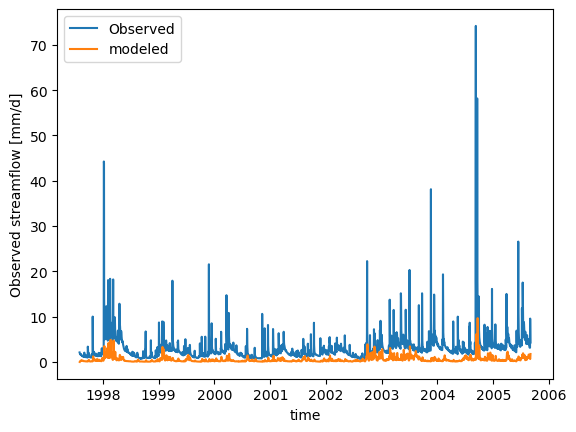

In [71]:
fig, ax = plt.subplots()
ds_caravan["Q"].plot(ax=ax,label='Observed')
ax.plot(time, Q_m,label="modeled")
ax.set_title("")
ax.legend();